In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit
#import pymc as pm
from scipy.integrate import odeint

%matplotlib inline

In [20]:
online = True

if online:
    COVID_CONFIRMED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
else:
    COVID_CONFIRMED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    COVID_DEATHS_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    COVID_RECOVERED_URL = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    


covid_confirmed = pd.read_csv(COVID_CONFIRMED_URL)
covid_deaths = pd.read_csv(COVID_DEATHS_URL)
covid_recovered = pd.read_csv(COVID_RECOVERED_URL)

covid_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
covid_confirmed.rename(columns={'Province/State':'State'}, inplace=True)
covid_deaths.rename(columns={'Province/State':'State'}, inplace=True)
covid_recovered.rename(columns={'Province/State':'State'}, inplace=True)


covid_confirmed.head()

,State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [21]:
Country = 'Russia'
population = {"Russia" : 146745098, "Italy" : 60317000, "China" : 1404328000}

data_Russia_confirmed = covid_confirmed[covid_confirmed.Country == Country].values[0, 4:].astype(int)

data = np.empty((3, data_Russia_confirmed.shape[0]), dtype=np.int64)
data[0] = data_Russia_confirmed

data[1] = covid_deaths   [covid_deaths.Country    == Country].values[0, 4:].astype(int)
data[2] = covid_recovered[covid_recovered.Country == Country].values[0, 4:].astype(int)

data_normed = data.astype(np.float64) / population[Country]
data_normed_only_conf = data_normed[0] - data_normed[1] - data_normed[2]

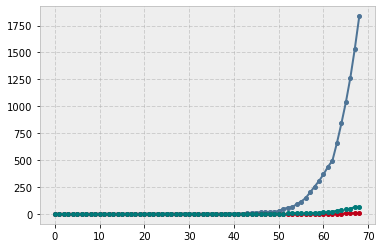

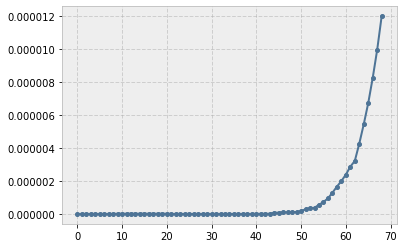

In [22]:
plt.plot(data.T);
plt.figure()
plt.plot(data_normed_only_conf);

In [23]:
@jit
def base_seir_model(init_vals, dt, N, params):
    res = np.empty((N, 4), dtype=np.float64)
    S = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    #print(I)
    return res


def seir_rhs(y, t, alpha, beta, gamma):
    S, E, I, R = y
    return [-beta*S*I, beta*S*I - alpha*E, alpha*E - gamma*I, gamma*I]

def base_seir_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max - 1, N)
    sol = odeint(seir_rhs, init_vals, t, args=params)
    #return sol[::int(1/dt)]
    return sol

@jit
def sirx_rhs(x, t, alpha, beta, k0, k):
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = (alpha*S - beta - (k0 + k))*I
    dxdt = (k0 + k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])


def base_sirx_model_rhs(x, params):
    alpha, beta, k0, k = params
    S, I, X, R = x
    dsdt = -alpha*S*I - k0*S
    didt = alpha*S*I - beta*I - k0*I - k*I
    dxdt = (k0+k)*I
    dRdt = k0*S + beta*I
    return np.array([dsdt, didt, dxdt, dRdt])

#@jit
def base_sirx_model_odeint(init_vals, dt, N, params):
    t_max = N*dt
    t = np.linspace(0, t_max - 1, N)
    sol = odeint(sirx_rhs, init_vals, t, args=params)
    #sol[np.isnan(sol)] = 1e20
    #sol[np.isinf(sol)] = 1e20
    return sol



# SIR Model (not working)
@jit
def base_sirf_model(init_vals, dt, N, params):
    res = np.empty((N, 3), dtype=np.float64)
    y = res[:, 0]
    E = res[:, 1]
    I = res[:, 2]
    R = res[:, 3]
    S[0], E[0], I[0], R[0] = init_vals
    alpha, beta, gamma = params
    for i in range(1, N):
        S[i] = S[i-1] - (beta*S[i-1]*I[i-1])*dt
        E[i] = E[i-1] + (beta*S[i-1]*I[i-1] - alpha*E[i-1])*dt
        I[i] = I[i-1] + (alpha*E[i-1] - gamma*I[i-1])*dt
        R[i] = R[i-1] + (gamma*I[i-1])*dt

    return res


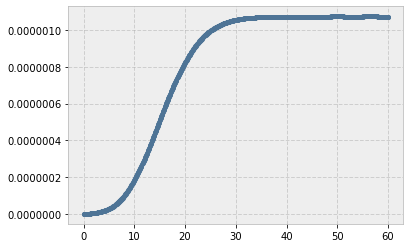

In [6]:
# Test SIRX
t_max = 60
dt = .1
N = int(t_max / dt) + 1
t = np.linspace(0, t_max, N)

x0 = np.array([1.0, 1e-8, 0.0, 0.0])
beta = 0.38 #d^{-1}
R0 = 3.07
alpha = R0*beta
k0 = 6e-2
k = 5e-2

params = alpha, beta, k0, k

results = base_sirx_model_odeint(x0, dt, N, params)

plt.plot(t, results[:, 2]);
#plt.plot(results[:, 1]);

In [65]:
#vals = []

data1 = data[0]
data1 = data1[data1>=3]
data1 = data1/population[Country]
#plt.plot(data1)

#true_cases = data_normed_only_conf[-20:]
#true_cases = data_normed_only_conf[data[0] >= 3]
#true_cases = data_normed[0][data[0] >= 3]
true_cases = data1


def obs(alpha_MC, beta_MC, k0_MC, k_MC, I0_MC, cf = 4, N = len(true_cases), type_ret=2):
        #global vals
        dt = 1.0/cf
        num = (N-1)*cf + 1
        res = base_sirx_model_odeint((1.0 - (I0_MC + true_cases[0]), I0_MC, true_cases[0], 0.0), dt, num, (alpha_MC, beta_MC, k0_MC, k_MC))
        rr = res.T[type_ret][::cf]
        #print(rr)
        #vals.append(rr)
        return rr
    

def loss_fn(alpha, beta, k0, k, I0):
#def loss_fn(x):
#    alpha, beta, k0, k, I0 = x
    loss_val = np.linalg.norm( obs(alpha, beta, k0, k, I0) - true_cases )
#    if np.isnan(loss_val) or np.isinf(loss_val):
#        loss_val = 1e100
    return loss_val

"""
num_days = len(true_cases)-1
times = np.linspace(0, num_days, num_days+1)

def compute_fit(alpha, beta, k0, k, I0):
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    predicted_cases = sol[:, 2]
    return np.linalg.norm(true_cases-predicted_cases)


def predict(alpha, beta, I0, k0, k, num_days):
    times = np.linspace(0, num_days, num_days+1)
    params = np.array([alpha, beta, k0, k])
    x0 = np.array([1.0, I0, true_cases[0], 0.0])
    rhs = lambda x, t: base_sirx_model_rhs(x, params)
    sol = odeint(rhs, x0, times)
    return sol

"""

In [25]:
import nevergrad as ng

In [34]:
def optimize():
    beta0 = 0.38 #d^{-1}
    R0 = 3.07
    alpha0 = R0*beta0
    #k0_0 = 1e-1
    #k_0 = 0.0

    alpha = ng.p.Scalar()
    alpha.value = alpha0
    alpha.value = 0.8921533322357904
    beta = ng.p.Scalar()
    beta.value = beta0
    beta.value = 0.6006857701497142
    I0 = ng.p.Scalar()
    I0.value = 1e-8
    I0.value = 2.0638693642381589e-07
    k0 = ng.p.Scalar()
    k = ng.p.Scalar()
    alpha.set_bounds(0.0, 10.0)
    beta.set_bounds(5e-2, 2.0)
    I0.set_bounds(0.0, 1e-4)
    k0.value = 1e-5
    k.value = 1e-5
    k0.value = 0.003774752347706235
    k.value = 0.018991858675810148
    #k0.set_bounds(0, 5e-2)
    #k.set_bounds(0, 5e-2)
    k0.set_bounds(0, 0.1)
    k.set_bounds(0, 0.1)

    instru = ng.p.Instrumentation(alpha, beta, k0, k, I0)
    optimizer = ng.optimizers.CMA(parametrization=instru, budget=20000, num_workers=6) # num_workers don't work :(
    #optimizer = ng.optimizers.CMA(parametrization=instru, budget=500000)

    recommendation = optimizer.minimize(loss_fn)
    #recommendation = optimizer.minimize(compute_fit)
    return recommendation

max_err = 1e100
for _ in range(30):
    print('.')
    recommendation = optimize()
    err = loss_fn(*recommendation.value[0])
    if err < max_err:
        max_err = err
        vals = recommendation.value[0]
        
max_err, vals
    

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:04:44 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 1.95 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 0.0001 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/parametrization/data.py:234: UserWarning: Bounds are 0.1 sigma away from each other at the closest, you should aim for at least 3 for better quality.
  warnings.warn(f"Bounds are {min_dist} sigma away from each other at the closest, "
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/nevergrad/optimization/base.p

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.333229e-09.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.685733e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.378398e-09.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.682262e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.016595e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.282895e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.663532e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -7.442661e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.700863e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.038744e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.441063e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.327186e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.666808e-03.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.586481e-03.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.164579e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.213689e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.700516e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.324365e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

NOTE (module=cma, iteration=2446):  
condition in coordinate system exceeded 1.2e+08, rescaled to 1.0e+00, 
condition changed from 1.3e+16 to 1.2e+13


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.530111e-17.
Consider to reformulate the objective function ()
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:06:29 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=377)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:07:29 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0278953982405452) = 2.795176905713851 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=2046)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.6e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=2481)
  ')')


.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:08:26 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=573)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.118323e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.113150e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.376648e-10.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.376645e-10.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.376637e-10.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.767772e-11.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.149072e-11.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.360086e-09.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.474331e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.881720e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.460926e-08.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.152792e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.142711e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.387608e-07.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.940377e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.471393e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.885864e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.284561e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.403559e-03.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.346952e-03.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.347703e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.869441e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.622350e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:12:53 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1167079813954213) = 3.05478123553113 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=463)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1898320793356072) = 3.2865292848637564 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=464)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2345209105931758) = 3.4367316245159625 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=465)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1991779580320947) = 3.317388768769863 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=466)
  ')')
/home/gleb/anaconda2/envs/py3/l

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.837871e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.139328e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.843554e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.446258e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.154408e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.154520e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.107512e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.375634e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.375714e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:13:50 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.105151627834027) = 3.0196823019824643 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=503)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0033286519928637) = 2.7273451185855024 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=504)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.0392652912843445) = 2.8271391273669435 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=506)
  ')')


NOTE (module=cma, iteration=1120):  
condition in coordinate system exceeded 1.8e+08, rescaled to 1.0e+00, 
condition changed from 2.0e+08 to 2.6e+03
.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:14:45 2020)
NOTE (module=cma, iteration=652):  
condition in coordinate system exceeded 1.6e+08, rescaled to 1.0e+00, 
condition changed from 8.3e+09 to 6.3e+08
NOTE (module=cma, iteration=855):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.3e+09 to 1.5e+08


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.2e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=1198)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -3.467507e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.420692e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.576730e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.107410e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.383041e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.103487e-12.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.626770e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.832687e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -6.307083e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -8.374968e-14.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.082526e-13.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:16:48 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1127405723820782) = 3.042685678799563 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=460)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.1869094170147987) = 3.2769378925844963 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=461)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2287291855719464) = 3.4168845498537515 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=462)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: sigma change np.exp(1.2490939969677135) = 3.487182128235305 clipped to np.exp(+-1) (class=CMAAdaptSigmaCSA method=update iteration=463)
  ')')


NOTE (module=cma, iteration=1384):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.2e+08 to 2.9e+02
.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:17:44 2020)


/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=983)
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.017923e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.006479e-06.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.038222e-05.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.060758e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -2.244873e-04.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.236047e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.234005e-02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.374538e-01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.842778e+00.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.221605e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -1.221533e+01.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.382815e+02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -4.378395e+02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matrix eigen decomposition failed with 
covariance matrix was not positive definite with a minimal eigenvalue of -5.123515e+02.
Consider to reformulate the objective function ()
  ')')
/home/gleb/anaconda2/envs/py3/lib/python3.6/site-packages/cma/utilities/utils.py:333: UserWarning: covariance matri

.
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=<module 'time' (built-in)>, Wed Apr  1 00:18:49 2020)
NOTE (module=cma, iteration=2151):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.9e+08 to 5.0e+05


(4.959735238009087e-07,
 (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05))

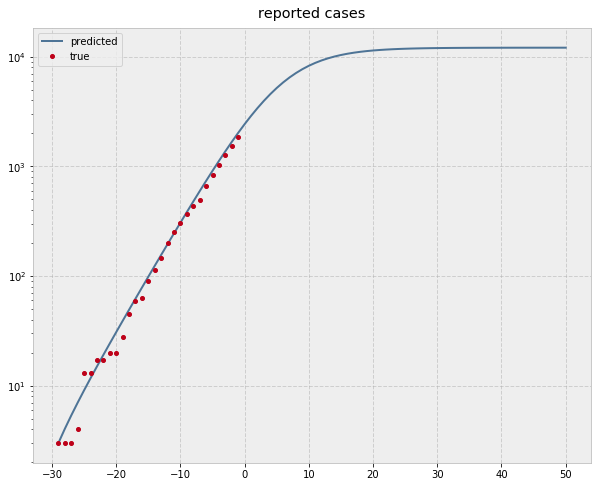

In [81]:
num_days = 80
time_scale = np.linspace(-len(true_cases), num_days - len(true_cases) - 1, num_days)
time_scale_true = np.linspace(-len(true_cases) , -1, len(true_cases))
plt.figure(figsize=(10, 8))
vals = (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=num_days), "-", label="predicted");
plt.plot(time_scale_true, population[Country]*true_cases, "o", label="true");
plt.legend();
plt.title('reported cases');
plt.yscale('log')

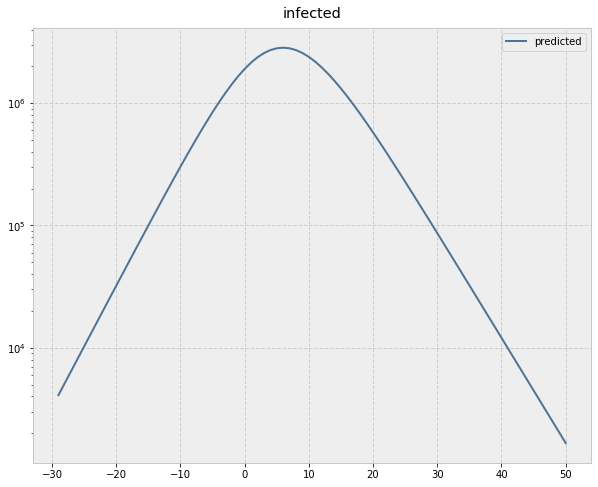

In [84]:
plt.figure(figsize=(10, 8))
vals = (1.2173437044675621,
  0.9855553151918058,
  0.0,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals
plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected');
plt.yscale('log');

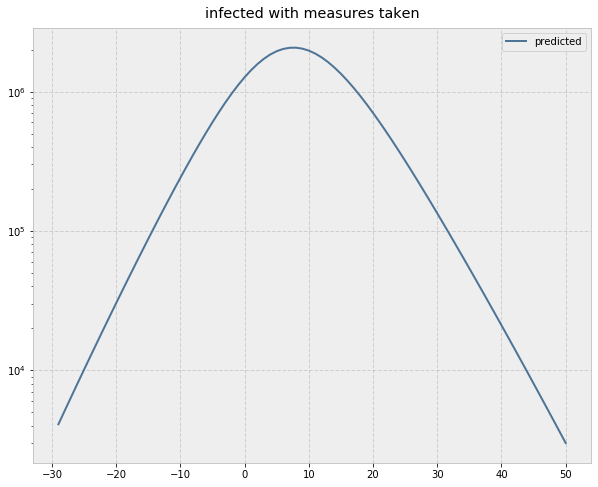

In [89]:
plt.figure(figsize=(10, 8))

vals = (1.2173437044675621,
  0.9855553151918058,
  1e-3,
  0.00022902367817583327,
  2.7873569184833206e-05)
alpha_g, beta_g, k0_g, k_g, I0_g = vals

plt.plot(time_scale, population[Country]*obs(alpha_g, beta_g, k0_g, k_g, I0_g, N=80, type_ret=1), "-", label="predicted");
plt.legend();
plt.title('infected with measures taken');
plt.yscale('log');

In [70]:
recommendation.value[0]

(1.4620735715158846,
 1.1550524698389562,
 0.00012016896136317736,
 0.09431369871672939,
 8.85266762057214e-08)

In [67]:
good_vals_1 = (0.8921533322357904,
 0.6006857701497142,
 0.003774752347706235,
 0.018991858675810148,
 2.0638693642381589e-07)

good_vals_2 = (1.4620735715158846,
 1.1550524698389562,
 0.00012016896136317736,
 0.09431369871672939,
 8.85266762057214e-08)


In [ ]:
(0.7028386750218786, 0.5248873953209352, 0.0026616813473804538, 0.0, 1e-05)

In [69]:
loss_fn(*good_vals_1), loss_fn(*recommendation.value[0])

(2.938729818873531e-06, 5.876705339440785e-07)

In [62]:
print(sorted(ng.optimizers.registry.keys()))

['ASCMA2PDEthird', 'ASCMADEQRthird', 'ASCMADEthird', 'AlmostRotationInvariantDE', 'BO', 'CM', 'CMA', 'CMandAS', 'CMandAS2', 'CMandAS3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteOnePlusOne', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'FCMA', 'HaltonSearch', 'HaltonSearchPlusMiddlePoint', 'HammersleySearch', 'HammersleySearchPlusMiddlePoint', 'LHSSearch', 'LargeHaltonSearch', 'LhsDE', 'MEDA', 'MPCEDA', 'MetaRecentering', 'MixES', 'MultiCMA', 'MultiScaleCMA', 'MutDE', 'NGO', 'NaiveIsoEMNA', 'NaiveTBPSA', 'NelderMead', 'NoisyBandit', 'NoisyDE', 'NoisyDiscreteOnePlusOne', 'NoisyOnePlusOne', 'ORandomSearch', 'OScrHammersleySearch', 'OnePlusOne', 'OptimisticDiscreteOnePlusOne', 'OptimisticNoisyOnePlusOne', 'PBIL', 'PCEDA', 'PSO', 'ParaPortfolio', 'Portfolio', 'Powell', 'QORandomSearch', 'QOScrHammersleySearch', 'QrDE', 'RCobyla', 'RPowell', 'RSQP', 'RandomSearch', 'RandomSearchPlusMiddlePoint', 'RealSpacePSO', 'RecES', 'Re